In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import re
import copy

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN


In [3]:
bcldirs=['180515_SL-HXR_0665_AFCHH2H3CCXY','180515_SL-HXS_0555_AFCHGYTGCCXY',
        '180515_SL-HXR_0666_BFCHGY7FCCXY','180515_SL-HXS_0556_BFCHH2FNCCXY']

for channel in range(32):
    print(channel)
    channelname=str(channel+1)
    for bcldir in bcldirs:
        gbc_cbc_file='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/data/count_barcodes/mismatches2/'+bcldir+'/A549_'+PROTEIN+'_'+channelname+'.'+bcldir+'.variantBarcodeCounts.gz.with_cellbc_and_UMI.gz'
        cur_data=pd.read_csv(gbc_cbc_file,compression='gzip',sep='\t',header=None)
        cur_data.columns=['gbc','r2','pos','strand','cbc','umi','alignments','read_name']
        cur_data['cbc']=cur_data['cbc']+'ch'+str(channel)
        if channel==0:
            gbc_data=cur_data
        else:
            gbc_data=pd.concat([gbc_data,cur_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [4]:
### import copy
gbc_data_original=copy.deepcopy(gbc_data)
gbc_data_original=gbc_data_original.drop_duplicates()
gbc_data_original.shape

(1017509, 8)

In [5]:
#keep only vbcs that map to - strand for vbcs, and to + strand for puro res
keep=[]
strand=list(gbc_data_original['strand'])
gbc=list(gbc_data_original['gbc'])
for i in range(gbc_data_original.shape[0]):
    cur_strand=strand[i]
    cur_gbc=gbc[i]
    if cur_strand=='-' and gbc!='Puro_res':
        keep.append(i)
    else:
        if cur_strand=='+' and gbc=='Puro_res':
            keep.append(i)
print('keep',len(keep),'total',gbc_data_original.shape[0])

gbc_data_filtered=copy.deepcopy(gbc_data_original)
gbc_data_filtered=gbc_data_filtered.iloc[keep,:]

keep 580666 total 1017509


In [6]:
import perturbseq as perturb
gbc_data=perturb.pp.compute_TPT(gbc_data_filtered)

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


In [7]:
print(gbc_data.shape)
print(gbc_data.head())

(518576, 6)
                   gbc                   cbc         umi  cbc-umi-r2-count  \
0            KRAS_T50P  AAAACAATCGGATGTTch20  ATAGGGCACC                 1   
1            KRAS_L79I  AAAACCTGTCCTTGCCch18  ATGGTATCTT                 1   
2            KRAS_P34L  AAAACGGGGTGGGTCAch31  AACGTATCAA                 1   
3            KRAS_I36M  AAAAGATGCACGTGAGch27  AGCCATCGCA                 1   
4  KRAS_p.Al66Al.198AG  AAAAGCAATCGTACGGch15  CCCATTGTTG                 1   

   cbc-umi-count  TPT  
0              1  1.0  
1              1  1.0  
2              1  1.0  
3              1  1.0  
4              1  1.0  


In [8]:
gbc_data_filtered.loc[:,['cbc','umi','r2']].drop_duplicates().shape

(518576, 3)

In [9]:
#now, compute lenient TPT that only looks at whether reads mapped to the same gbc, 
#even if they have diff sequences

gbc_data_filtered_lenient=copy.deepcopy(gbc_data_filtered)
gbc_data_filtered_lenient['r2']=gbc_data_filtered_lenient['gbc']
gbc_data=perturb.pp.compute_TPT(gbc_data_filtered_lenient)

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,20)
plt.xlim(0,1)
plt.show()

print(gbc_data['TPT'].describe())

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result
count    428350.000000
mean          0.999993
std           0.001939
min           0.333333
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: TPT, dtype: float64


In [10]:
#quickly look at the reads with bad TPTs
#there are v few of them (yay!)

gbc_data.loc[gbc_data['TPT']<1,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
43138,KRAS_G60D,ACGTCAATCAACACCAch8,AAACTTTTTC,2,3,0.666667
43139,KRAS_L159S,ACGTCAATCAACACCAch8,AAACTTTTTC,1,3,0.333333
52253,KRAS_G60D,AGAATAGTCCTCCTAGch31,CACTCCTAGT,2,3,0.666667
52254,KRAS_p.Thr158Thr.474AG,AGAATAGTCCTCCTAGch31,CACTCCTAGT,1,3,0.333333
124204,KRAS_Q61L,CATATTCCACGGCGTTch28,TACGGAATTG,1,2,0.500000


In [11]:
gbc_data_filtered.loc[gbc_data_filtered['cbc']=="ACGTCAATCAACACCAch8",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name,cbcumi,cbcumir2
244,KRAS_G60D,CCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGC...,56,-,ACGTCAATCAACACCAch8,CCTATCATGA,0,E00173:665:HH2H3CCXY:6:1115:9607:22141,ACGTCAATCAACACCAch8-CCTATCATGA,ACGTCAATCAACACCAch8-CCTATCATGA+CCTCTAGGTTAATTA...
3909,KRAS_G60D,ACGCTAGCTTCTCCTCGTTACTCAGCCCGGGCATTTTGTCTTACAT...,76,-,ACGTCAATCAACACCAch8,AAACTTTTTC,0,E00173:665:HH2H3CCXY:6:1211:25469:40759,ACGTCAATCAACACCAch8-AAACTTTTTC,ACGTCAATCAACACCAch8-AAACTTTTTC+ACGCTAGCTTCTCCT...
4727,KRAS_G60D,AGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGT...,19,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00173:665:HH2H3CCXY:6:2202:28737:44521,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+AGGCACAGTCGAGGC...
3717,KRAS_G60D,TCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGCCC...,58,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00342:555:HGYTGCCXY:6:1216:7121:63929,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+TCTAGGTTAATTAAC...
3718,KRAS_G60D,TCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGCCC...,58,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00342:555:HGYTGCCXY:6:1216:7172:64052,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+TCTAGGTTAATTAAC...
4883,KRAS_L159S,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCGTGGTTCGAC...,53,-,ACGTCAATCAACACCAch8,AAACTTTTTC,0,E00342:555:HGYTGCCXY:6:2224:11891:32109,ACGTCAATCAACACCAch8-AAACTTTTTC,ACGTCAATCAACACCAch8-AAACTTTTTC+GGCCCTCTAGGTTAA...
2087,KRAS_G60D,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTCGTTACTC...,53,-,ACGTCAATCAACACCAch8,GTAGTTTGGC,0,E00173:666:HGY7FCCXY:6:1202:25611:8306,ACGTCAATCAACACCAch8-GTAGTTTGGC,ACGTCAATCAACACCAch8-GTAGTTTGGC+GGCCCTCTAGGTTAA...
2148,KRAS_G60D,GTTAATTAACACCACGCTAGCTTCTCCTCGTTACTCAGCCCGGGCA...,63,-,ACGTCAATCAACACCAch8,TTGTTTAATT,0,E00173:666:HGY7FCCXY:6:1205:15240:53100,ACGTCAATCAACACCAch8-TTGTTTAATT,ACGTCAATCAACACCAch8-TTGTTTAATT+GTTAATTAACACCAC...
6797,KRAS_G60D,GATGGCTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTTT...,2,-,ACGTCAATCAACACCAch8,ATCGGTGCTT,0,E00173:666:HGY7FCCXY:6:2104:14103:27292,ACGTCAATCAACACCAch8-ATCGGTGCTT,ACGTCAATCAACACCAch8-ATCGGTGCTT+GATGGCTGGCAACTA...
6237,KRAS_G60D,CTAGAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTC...,14,-,ACGTCAATCAACACCAch8,AAACTTTTTC,0,E00342:556:HH2FNCCXY:6:2116:3234:69537,ACGTCAATCAACACCAch8-AAACTTTTTC,ACGTCAATCAACACCAch8-AAACTTTTTC+CTAGAAGGCACAGTC...


In [12]:
gbc_data_filtered.loc[gbc_data_filtered['cbc']=="AGAATAGTCCTCCTAGch31",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name,cbcumi,cbcumir2
2504,KRAS_G60D,TAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTCG...,47,-,AGAATAGTCCTCCTAGch31,TCTCAAGAAA,0,E00173:665:HH2H3CCXY:8:1214:22698:22563,AGAATAGTCCTCCTAGch31-TCTCAAGAAA,AGAATAGTCCTCCTAGch31-TCTCAAGAAA+TAAACGGGCCCTCT...
6438,KRAS_G60D,GAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACAC...,29,-,AGAATAGTCCTCCTAGch31,TCCGCCAAAA,0,E00173:665:HH2H3CCXY:8:1214:16336:35309,AGAATAGTCCTCCTAGch31-TCCGCCAAAA,AGAATAGTCCTCCTAGch31-TCCGCCAAAA+GAGGCTGATCAGCG...
7598,KRAS_G60D,GGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTT...,20,-,AGAATAGTCCTCCTAGch31,TTCAGGCCGC,0,E00173:665:HH2H3CCXY:8:2203:16498:2751,AGAATAGTCCTCCTAGch31-TTCAGGCCGC,AGAATAGTCCTCCTAGch31-TTCAGGCCGC+GGCACAGTCGAGGC...
7717,KRAS_G60D,GCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATCAACACCAC...,32,-,AGAATAGTCCTCCTAGch31,CACTCCTAGT,0,E00173:665:HH2H3CCXY:8:2206:25489:51975,AGAATAGTCCTCCTAGch31-CACTCCTAGT,AGAATAGTCCTCCTAGch31-CACTCCTAGT+GCTGATCAGCGGGT...
2277,KRAS_G60D,CTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACG...,7,-,AGAATAGTCCTCCTAGch31,TAGATCACCT,0,E00173:666:HGY7FCCXY:8:1109:12225:37014,AGAATAGTCCTCCTAGch31-TAGATCACCT,AGAATAGTCCTCCTAGch31-TAGATCACCT+CTGGCAACTAGAAG...
3344,KRAS_G60D,GAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAG...,17,-,AGAATAGTCCTCCTAGch31,CACTCCTAGT,0,E00173:666:HGY7FCCXY:8:2104:8897:39616,AGAATAGTCCTCCTAGch31-CACTCCTAGT,AGAATAGTCCTCCTAGch31-CACTCCTAGT+GAAGGCACAGTCGA...
5341,KRAS_G60D,AGATGGCTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTT...,1,-,AGAATAGTCCTCCTAGch31,CTCTACTTGG,0,E00173:666:HGY7FCCXY:8:1219:20212:25851,AGAATAGTCCTCCTAGch31-CTCTACTTGG,AGAATAGTCCTCCTAGch31-CTCTACTTGG+AGATGGCTGGCAAC...
5972,KRAS_G60D,CGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACA...,28,-,AGAATAGTCCTCCTAGch31,ACCGGAAAGG,0,E00173:666:HGY7FCCXY:8:2201:18233:38456,AGAATAGTCCTCCTAGch31-ACCGGAAAGG,AGAATAGTCCTCCTAGch31-ACCGGAAAGG+CGAGGCTGATCAGC...
5973,KRAS_G60D,CGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACA...,28,-,AGAATAGTCCTCCTAGch31,ACCGGAAAGG,0,E00173:666:HGY7FCCXY:8:2201:18233:41022,AGAATAGTCCTCCTAGch31-ACCGGAAAGG,AGAATAGTCCTCCTAGch31-ACCGGAAAGG+CGAGGCTGATCAGC...
3691,KRAS_G60D,TTATACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCTC...,46,-,AGAATAGTCCTCCTAGch31,AAATTCTTTT,0,E00342:556:HH2FNCCXY:8:2220:28209:31511,AGAATAGTCCTCCTAGch31-AAATTCTTTT,AGAATAGTCCTCCTAGch31-AAATTCTTTT+TTATACGGGCCCTC...


In [13]:
#really look like chimeras

In [14]:
TPT_threshold=1.0

counts_with_tpt=gbc_data
print(counts_with_tpt.head())

keep=list([x>=TPT_threshold for x in counts_with_tpt['TPT']])
filtered=counts_with_tpt[keep]
print(filtered.shape)
print(filtered.head())

                   gbc                   cbc         umi  cbc-umi-r2-count  \
0            KRAS_T50P  AAAACAATCGGATGTTch20  ATAGGGCACC                 1   
1            KRAS_L79I  AAAACCTGTCCTTGCCch18  ATGGTATCTT                 1   
2            KRAS_P34L  AAAACGGGGTGGGTCAch31  AACGTATCAA                 1   
3            KRAS_I36M  AAAAGATGCACGTGAGch27  AGCCATCGCA                 1   
4  KRAS_p.Al66Al.198AG  AAAAGCAATCGTACGGch15  CCCATTGTTG                 1   

   cbc-umi-count  TPT  
0              1  1.0  
1              1  1.0  
2              1  1.0  
3              1  1.0  
4              1  1.0  
(428344, 6)
                   gbc                   cbc         umi  cbc-umi-r2-count  \
0            KRAS_T50P  AAAACAATCGGATGTTch20  ATAGGGCACC                 1   
1            KRAS_L79I  AAAACCTGTCCTTGCCch18  ATGGTATCTT                 1   
2            KRAS_P34L  AAAACGGGGTGGGTCAch31  AACGTATCAA                 1   
3            KRAS_I36M  AAAAGATGCACGTGAGch27  AGCCATCGCA       

In [15]:
outpath=results_prefix+'.anno'
print(outpath)

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/KRAS/processed_data/A549.KRAS.anno


In [16]:
filtered_counts=filtered.groupby(['cbc','gbc','umi']).sum()
print(filtered_counts.shape)
filtered_counts.head()

filtered_counts.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')

filtered_counts=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')
print(filtered_counts.shape)
filtered_counts.head()

#go through each line, make 2 matrices
#one gives us the total reads per cbc-gbc, one gives us the umis.

umi_counts={}
read_counts={}
for i in range(filtered_counts.shape[0]):
    if i%100000==0:
        print(i)
    cbc=filtered_counts.loc[i,'cbc']
    gbc=filtered_counts.loc[i,'gbc']
    umi=filtered_counts.loc[i,'umi']
    count=filtered_counts.loc[i,'cbc-umi-count']
    if cbc not in umi_counts:
        umi_counts[cbc]={}
        read_counts[cbc]={}
    if gbc not in umi_counts[cbc]:
        umi_counts[cbc][gbc]=set()
        read_counts[cbc][gbc]=0
    umi_counts[cbc][gbc].add(umi)
    read_counts[cbc][gbc]+=count
    
cbcs=list(set(filtered_counts['cbc']))
gbcs=list(set(filtered_counts['gbc']))
m_reads=np.zeros((len(cbcs),len(gbcs)))
m_umis=np.zeros((len(cbcs),len(gbcs)))
for cbc_idx in range(len(cbcs)):
    if cbc_idx%10000==0:
        print(cbc_idx)
    cbc=cbcs[cbc_idx]
    for gbc_idx in range(len(gbcs)):
        gbc=gbcs[gbc_idx]
        if cbc in umi_counts:
            if gbc in umi_counts[cbc]:
                count=len(list(umi_counts[cbc][gbc]))
                m_umis[cbc_idx,gbc_idx]=count
                m_reads[cbc_idx,gbc_idx]=read_counts[cbc][gbc]

(428344, 3)
(428344, 6)
0
100000
200000
300000
400000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [17]:
m_umis_df=pd.DataFrame(m_umis)
m_umis_df.index=cbcs
m_umis_df.columns=gbcs

m_reads_df=pd.DataFrame(m_reads)
m_reads_df.index=cbcs
m_reads_df.columns=gbcs

m_umis_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.gz',compression='gzip')
m_reads_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.gz',compression='gzip')

In [18]:
m_reads_df.head()

,KRAS_G60S,KRAS_G60D,KRAS_G13C,KRAS_P34R,KRAS_G13E,KRAS_N26Y,KRAS_Q61P,KRAS_K147T,KRAS_AG11TD,KRAS_A146T,...,KRAS_R68S,KRAS_G12D,KRAS_T158A,KRAS_T20M,KRAS_p.Gly77Al.230GC,KRAS_Q61K,KRAS_p.Ser136AsnGA,KRAS_V14L,KRAS_R149K,KRAS_H166Y
GCAATCAGTCAGAAGCch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGTCTGAGACCCACCch26,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTTCATTGTCCTCGTCch19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGCCGTGTGGTGTAGch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0
CCACCTAAGAAGGACAch22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#map the variant names to nice standardized variant names
variants=m_reads_df.columns
print(variants)

Index(['KRAS_G60S', 'KRAS_G60D', 'KRAS_G13C', 'KRAS_P34R', 'KRAS_G13E',
       'KRAS_N26Y', 'KRAS_Q61P', 'KRAS_K147T', 'KRAS_AG11TD', 'KRAS_A146T',
       'KRAS_p.Ser17Ser.51TC', 'KRAS_L159S', 'KRAS_G13R', 'TP53_p.Pro295Pro',
       'KRAS_V14I', 'KRAS_T50P', 'KRAS_K5E', 'KRAS_p.Phe141Leu',
       'KRAS_p.Lys179Ar.536AG', 'KRAS_I36M', 'KRAS_R164Q',
       'KRAS_p.Thr20Thr.60GA', 'KRAS_T74A', 'KRAS_p.Thr144Thr.432AG',
       'KRAS_p.Vl8Vl.24AG', 'KRAS_Q61R', 'KRAS_A59T', 'KRAS_p.Me170Leu.508AT',
       'Puro_res', 'KRAS_Q61A', 'KRAS_A146V', 'KRAS_T144P', 'KRAS_A59E',
       'KRAS_p.Al66Al.198AG', 'KRAS_Q99E', 'KRAS_G12S', 'KRAS_G12I',
       'KRAS_p.Thr74Thr.222TC', 'KRAS_K147N', 'KRAS_K117N', 'KRAS_G12V',
       'KRAS_I163S', 'KRAS_A59G', 'KRAS_G60V', 'KRAS_p.Thr50Thr.150CG',
       'KRAS_Q22K', 'KRAS_p.Lys178Lys.534AG', 'KRAS_p.Lys169Lys.507GA',
       'KRAS_G12Y', 'KRAS_p.Gly75Al.224GC', 'KRAS_p.Al130VlCT', 'KRAS_G12A',
       'KRAS_R41K', 'KRAS_K117R', 'KRAS_G12C', 'KRAS_p.Lys88Lys.2

In [20]:
import re
variants_newnames=[]
positions=[]

for i in range(len(variants)):
    
    #cur_name=re.sub('Asp','D',cur_name)
    cur_name=re.sub('CT','',re.sub('GA','',re.sub('p.','pstuff',
                                                  re.sub('-','',
                                                         re.sub('KRAS_','',
                                                                re.sub('Asp','D',variants[i])))).split('.')[0]))
    if cur_name=='Puro_res':
        variants_newnames.append('Puro_res')
        continue
    if cur_name=='H166Y':
        cur_name='Y166H'
        #continue
    cur_name=re.sub('Glu','E',cur_name)
    cur_name=re.sub('Cys','C',cur_name)
    cur_name=re.sub('Met','M',cur_name)
    cur_name=re.sub('Me','M',cur_name)
    cur_name=re.sub('Phe','F',cur_name)
    cur_name=re.sub('Lys','K',cur_name)
    cur_name=re.sub('Vl','V',cur_name)
    cur_name=re.sub('Pro','P',cur_name)
    cur_name=re.sub('Ar','R',cur_name)
    cur_name=re.sub('Thr','T',cur_name)
    cur_name=re.sub('Ser','S',cur_name)
    cur_name=re.sub('Leu','L',cur_name)
    cur_name=re.sub('Tyr','Y',cur_name)
    cur_name=re.sub('His','H',cur_name)
    cur_name=re.sub('Al','A',cur_name)
    cur_name=re.sub('Gly','G',cur_name)
    cur_name=re.sub('Gln','Q',cur_name)
    cur_name=re.sub('Ile','I',cur_name) 
    cur_name=re.sub('Asn','N',cur_name)
    cur_name=re.sub('pstuff','',cur_name)  
    print(cur_name)
    
    if cur_name=='WT':
        position=0
    else:
        position=int(re.sub(r"\D", "", cur_name))
    positions.append(position)
    
    variants_newnames.append(cur_name)

G60S
G60D
G13C
P34R
G13E
N26Y
Q61P
K147T
AG11TD
A146T
S17S
L159S
G13R
TP53_P295P
V14I
T50P
K5E
F141L
K179R
I36M
R164Q
T20T
T74A
T144T
V8V
Q61R
A59T
M170L
Q61A
A146V
T144P
A59E
A66A
Q99E
G12S
G12I
T74T
K147N
K117N
G12V
I163S
A59G
G60V
T50T
Q22K
K178K
K169K
G12Y
G75A
A130V
G12A
R41K
K117R
G12C
K88K
G13V
Q61L
Q25H
L52F
E31K
C185Y
AG59GV
L79I
D119G
A155G
T58I
Q22H
Q61H
V112I
M111L
D57N
G12F
T127T
D33E
T20R
WT
P34L
P110S
D173D
L19F
R135T
D30D
C118S
A146P
K176Q
G12R
E63K
T158T
T50I
R68S
G12D
T158A
T20M
G77A
Q61K
S136N
V14L
R149K
Y166H


In [21]:
print(len(variants))

100


In [22]:
m_umis_df=m_umis_df.loc[:,m_reads_df.columns]

In [23]:
m_reads_df.columns=variants_newnames
m_umis_df.columns=variants_newnames

In [24]:
m_umis_df.head()

,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,AG11TD,A146T,...,R68S,G12D,T158A,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H
GCAATCAGTCAGAAGCch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGTCTGAGACCCACCch26,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTTCATTGTCCTCGTCch19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGCCGTGTGGTGTAGch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
CCACCTAAGAAGGACAch22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
m_umis_df=m_umis_df.drop(columns=['Puro_res','TP53_P295P'])

In [26]:
m_reads_df=m_reads_df.drop(columns=['Puro_res','TP53_P295P'])

In [27]:
new_cells=[]
idx=list(m_umis_df.index)
for i in range(m_umis_df.shape[0]):
    new_cells.append('KRAS.'+idx[i])
m_umis_df['cell']=new_cells
m_reads_df['cell']=new_cells

In [28]:
m_umis_df.head()

,G60S,G60D,G13C,P34R,G13E,N26Y,Q61P,K147T,AG11TD,A146T,...,G12D,T158A,T20M,G77A,Q61K,S136N,V14L,R149K,Y166H,cell
GCAATCAGTCAGAAGCch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KRAS.GCAATCAGTCAGAAGCch31
AAGTCTGAGACCCACCch26,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KRAS.AAGTCTGAGACCCACCch26
GTTCATTGTCCTCGTCch19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KRAS.GTTCATTGTCCTCGTCch19
TTGCCGTGTGGTGTAGch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,KRAS.TTGCCGTGTGGTGTAGch31
CCACCTAAGAAGGACAch22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KRAS.CCACCTAAGAAGGACAch22


In [29]:
m_umis_df.columns

Index(['G60S', 'G60D', 'G13C', 'P34R', 'G13E', 'N26Y', 'Q61P', 'K147T',
       'AG11TD', 'A146T', 'S17S', 'L159S', 'G13R', 'V14I', 'T50P', 'K5E',
       'F141L', 'K179R', 'I36M', 'R164Q', 'T20T', 'T74A', 'T144T', 'V8V',
       'Q61R', 'A59T', 'M170L', 'Q61A', 'A146V', 'T144P', 'A59E', 'A66A',
       'Q99E', 'G12S', 'G12I', 'T74T', 'K147N', 'K117N', 'G12V', 'I163S',
       'A59G', 'G60V', 'T50T', 'Q22K', 'K178K', 'K169K', 'G12Y', 'G75A',
       'A130V', 'G12A', 'R41K', 'K117R', 'G12C', 'K88K', 'G13V', 'Q61L',
       'Q25H', 'L52F', 'E31K', 'C185Y', 'AG59GV', 'L79I', 'D119G', 'A155G',
       'T58I', 'Q22H', 'Q61H', 'V112I', 'M111L', 'D57N', 'G12F', 'T127T',
       'D33E', 'T20R', 'WT', 'P34L', 'P110S', 'D173D', 'L19F', 'R135T', 'D30D',
       'C118S', 'A146P', 'K176Q', 'G12R', 'E63K', 'T158T', 'T50I', 'R68S',
       'G12D', 'T158A', 'T20M', 'G77A', 'Q61K', 'S136N', 'V14L', 'R149K',
       'Y166H', 'cell'],
      dtype='object')

In [30]:
m_umis_df['cell']=list(m_umis_df.index)
m_reads_df['cell']=list(m_reads_df.index)

In [31]:
m_umis_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.mut_std.gz',index=False)
m_reads_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.mut_std.gz',index=False)

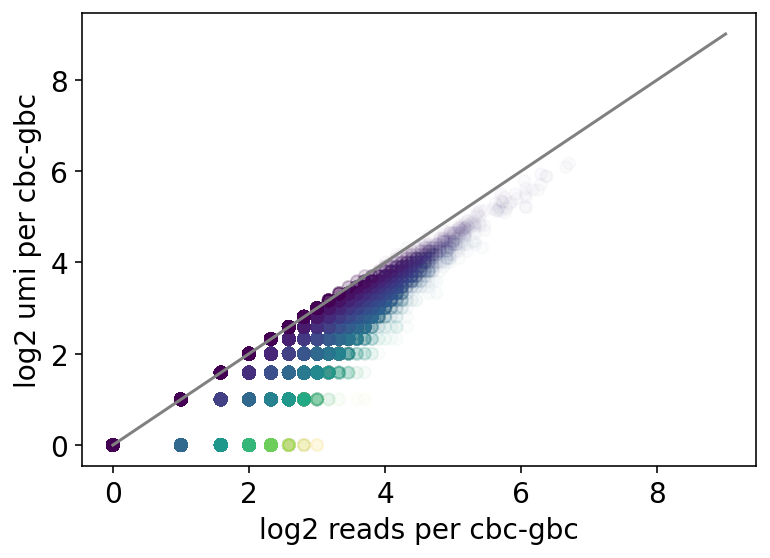

In [32]:
%matplotlib inline
plt.scatter(np.log2(m_reads.flatten()[m_reads.flatten()>0.0]),
            np.log2(m_umis.flatten()[m_umis.flatten()>0.0]),alpha=0.02,
            c=np.log2(m_reads.flatten()[m_reads.flatten()>0.0])-np.log2(m_umis.flatten()[m_umis.flatten()>0.0]))
plt.xlabel('log2 reads per cbc-gbc')
plt.ylabel('log2 umi per cbc-gbc')
plt.plot(np.arange(0, 10), np.arange(0, 10),color='gray')
plt.grid(False)
plt.show()

Cell2variant files here
===

In [33]:
print(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.mut_std.gz')

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/KRAS/processed_data/A549.KRAS.anno.vbc_TPTfiltered1.0_umi_counts.mut_std.gz


In [36]:
m_umis_df.iloc[:200,:].index

Index(['GCAATCAGTCAGAAGCch31', 'AAGTCTGAGACCCACCch26', 'GTTCATTGTCCTCGTCch19',
       'TTGCCGTGTGGTGTAGch31', 'CCACCTAAGAAGGACAch22', 'GTAGTCACAGGCAGATch21',
       'TGAAAGAGTAAACGCGch31', 'TGAAAGACAGCCTATAch31', 'CAGCTGGTCGAGGTAGch1',
       'ACACCTCAACAACCTGch21',
       ...
       'GACTAACCACATTTCTch22', 'GTAACTGAGGGTCGATch6', 'CTCATTAGTGTAACGGch8',
       'NCTGGGTGTTGAGGTGch15', 'GGTGAAGTCGTAGGTTch19', 'TTCTCCTGTAATCGTCch14',
       'AAGTCTGTCCTTGCCAch0', 'GATGCTAGTCCTAGCGch2', 'CAAGATCTCAGAGGTGch4',
       'ACTTTCATCCACTGGGch30'],
      dtype='object', length=200)